<ipython-input-2-390bee9711aa>:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_df_minus['angle'] = y_df_minus.angle * -1


63.339053376684504 0.05595307786128994 27     0.791520
28     0.791043
29     0.790736
30     0.790730
31     0.790749
         ...   
253    0.797270
254    0.797523
255    0.798532
256    0.798797
257    0.799480
Length: 231, dtype: float64


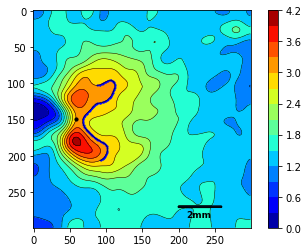

In [2]:
import DIC.DIC as dic
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import fracture

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Material property
n_hardening=17
yield_strength=535.435
poisson_ratio=0
alpha=0.585
In=2.78
youngs_modulus=71.7*1000

# Img parameter
set_angle = 60
down_level, up_level = 10,13
ratio = 2/60
left, right, up_down = 50,250,150


path = r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC'
save_path =r'E:\experiment data\aluminum\2021-03-30\AL IMAGE\CTS_UVon_HSC/Output'
image = dic.load_file(path)
tension_data = np.array(pd.read_csv(path+'/stress_ml.csv', encoding='CP949', delimiter=' ',header=None))
strain_hardening = np.array(pd.read_excel(path+'/book17.xlsx',header=None))


crack_tip = [[400,207],[397,210],[389,205],[387,202],[386,200]] # y, x


i = 0 ##ref
j = 4##cur

cur = list(image.keys())[j]

src_reference = image['ff0870'][:,:,1][crack_tip[i][0]-up_down:crack_tip[i][0]+up_down,crack_tip[i][1]-left:crack_tip[i][1]+right]
src_current = image[cur][:,:,1][crack_tip[j][0]-up_down:crack_tip[j][0]+up_down,crack_tip[j][1]-left:crack_tip[j][1]+right]

dst = cv2.subtract(src_current,src_reference)
dst = dst.astype(float)
dst = np.where(dst>10, dst*0, dst)
gas = cv2.GaussianBlur(dst,(0,0),10)
gas[270:272,200:260] = 0


plt.imshow(src_current, cmap='gray')
# plt.axis('off')
csf = plt.contourf(gas, 15, cmap = 'jet')
CS = plt.contour(gas, 15, colors='black', linewidths = 0.5)

plt.colorbar(csf)
plt.text( 210,285, '2mm', fontsize=9, fontweight='bold')


max_crack_tip = [np.argmax(gas)%(left+right), up_down]
# max_crack_tip = [np.argmax(gas)%(left+right), np.argmax(gas)//(left+right)]#x,y
plt.scatter(max_crack_tip[0],max_crack_tip[1], color= 'black', s=10)

x = []
y = []
level_list = []

for level in range(down_level,up_level+1):
    x_num = CS.allsegs[level][0][:,0]
    y_num = CS.allsegs[level][0][:,1]
    x = np.append(x, x_num)
    y = np.append(y, y_num)

    for _ in range(len(x_num)):
        level_list = np.append(level_list,level)


vector_1 = [1,0]
vector_2 = [x-max_crack_tip[0], y-max_crack_tip[1]]
dot_product = np.dot(vector_1 / np.linalg.norm(vector_1), vector_2 / np.linalg.norm(vector_2,axis=0))
angle = np.rad2deg(np.arccos(dot_product))

df = pd.DataFrame({'level':level_list, 'x': x, 'y': y, 'angle' : angle})
x_df = df['x'] - max_crack_tip[0] > 0
df = df[x_df]
y_df_minus = df[df['y'] - max_crack_tip[1] > 0]
y_df_minus['angle'] = y_df_minus.angle * -1
y_df_plus = df[df['y'] - max_crack_tip[1] <= 0]
df = y_df_plus.append(y_df_minus)
df = df[df['angle']<=set_angle]
df = df[df['angle']>=set_angle*-1]
df['r'] = np.sqrt(np.power(df['x']- max_crack_tip[0],2)+np.power(df['y']- max_crack_tip[1],2)) * ratio

hardening_plus=np.vstack((strain_hardening[:,0],strain_hardening[:,4])).transpose()
hardening_minus = np.flip(np.vstack((strain_hardening[:,0]*-1,strain_hardening[:,4])).transpose(), axis=0)
hardening = np.vstack((hardening_minus, hardening_plus))

ml=[]
effective_stress=[]
theta_list = []



for y,x,theta in np.array(df[['y','x','angle']]):
    current_ml = gas[np.round(y).astype(int),np.round(x).astype(int)]
    ml = np.append(ml, current_ml)
    effective_stress = np.append(effective_stress, tension_data[find_nearest(tension_data[:,1], current_ml),0])
    theta_list = np.append(theta_list, hardening[find_nearest(hardening[:,0],theta),1])


df['ml'] = ml
df['effective_stress'] = effective_stress
df['hardening_stress'] = theta_list

plt.scatter(df['x'],df['y'],color='blue',s=0.5)

plastic_k = df.effective_stress / (np.power(df.r*0.001,-1/(n_hardening+1)) * df.hardening_stress * yield_strength)
j_integral = (np.power(plastic_k.mean(),(n_hardening+1)) * alpha * yield_strength**2 * In)/ youngs_modulus
elastic_k1 = np.sqrt((j_integral * youngs_modulus) / (1 - poisson_ratio**2))


print(elastic_k1,j_integral, plastic_k)



In [3]:
df






,level,x,y,angle,r,ml,effective_stress,hardening_stress
27,10.0,87.000000,102.885793,59.276960,1.826882,3.002400,593.618771,0.98676
28,10.0,88.000000,102.815906,58.424538,1.846119,3.003985,593.582585,0.98787
29,10.0,89.000000,102.663342,57.635182,1.868083,3.007474,593.532482,0.98882
30,10.0,90.000000,102.439164,56.903821,1.892392,2.990053,593.587900,0.98963
31,10.0,91.000000,102.152456,56.225756,1.918734,2.996497,593.548170,0.99030
...,...,...,...,...,...,...,...,...
253,10.0,94.309368,205.000000,-57.300003,2.178621,3.006587,593.532229,0.98913
254,10.0,94.000000,205.203045,-57.624363,2.178781,3.006587,593.532229,0.98882
255,10.0,93.000000,205.807679,-58.648758,2.178301,2.993307,593.526915,0.98755
256,10.0,92.652759,206.000000,-58.996569,2.177794,2.993307,593.526915,0.98721


In [ ]:
theta_theta = np.rad2deg(np.arange(-1*np.pi, np.pi, .01)[1:])
theta_theta_list = []
r_list = []

for level in range(down_level,up_level+1):
    sigma_effective = df[df.level==level].effective_stress.mean()
    theta_theta_list = np.append(theta_theta_list, theta_theta)
    for degree in theta_theta:
        r = ( (hardening[find_nearest(hardening[:,0],degree),1] * yield_strength * plastic_k.mean())/ sigma_effective)**(n_hardening+1) *1000 / ratio
        r_list = np.append(r_list,r)


von_po = fracture.pol2cart(r_list.reshape(-1,1), theta_theta_list.reshape(-1,1))
#
plt.scatter(von_po[:,0]+max_crack_tip[0],von_po[:,1]+max_crack_tip[1], s=0.1, c='white')


grid = dst

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(6,10))

ax1.imshow(grid, extent=[0,100,0,1],cmap = 'jet')
ax1.set_title('Default')


ax2.imshow(grid,extent=[0,10,0,10] , cmap='jet',aspect='auto')
ax2.set_title('Manually Set Aspect')

plt.tight_layout()
plt.savefig(save_path+'/%s.png'%str(j))
plt.show()


